In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("../data/fraud_mock.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time_ind          int64  
 1   transac_type      object 
 2   amount            float64
 3   src_acc           object 
 4   src_bal           float64
 5   src_new_bal       float64
 6   dst_acc           object 
 7   dst_bal           float64
 8   dst_new_bal       float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Initial Data Inspection

In [7]:
df.head()

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,acc910286,170136.0,160296.36,acc298089,0.0,0.0,0,0
1,1,PAYMENT,1864.28,acc6597009,21249.0,19384.72,acc8726693,0.0,0.0,0,0
2,1,TRANSFER,181.00,acc1796908,181.0,0.00,acc4938640,0.0,0.0,1,0
3,1,CASH_OUT,181.00,acc4182296,181.0,0.00,acc1221153,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,acc7841596,41554.0,29885.86,acc5599142,0.0,0.0,0,0


In [8]:
df.describe()

,time_ind,amount,src_bal,src_new_bal,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
#check for missing values
df.isna().sum()

time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64

There are no missing values in this dataset, which reflects that the dataset is complete and does not require imputations.

In [10]:
#check for duplicated rows
df.duplicated().sum()

np.int64(0)

There are no duplicated data points in this dataset, supporting the integrity of the dataset and avoid faulty training from redundant transactions.

# Data Exploration

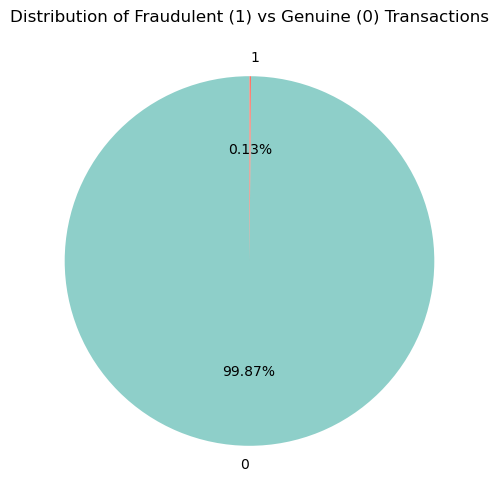

In [11]:
#check target class distribution in data set
fraud_distribution = df['is_fraud'].value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.pie(fraud_distribution, labels=fraud_distribution.index, autopct='%1.2f%%', startangle=90, colors=['#8ECFC9', '#FF6F61'])
plt.title('Distribution of Fraudulent (1) vs Genuine (0) Transactions')
plt.show()

In the case of fraud detection, it is common that the majority of transactions in the dataset would be non-fraud. We can observe that this is true for this dataset, which is highly imbalanced with only 0.13% of transactions being fradulent.

To further explore the dataset, we observe each data columns. Note that src_acc and dst_acc is ID-like and should not affect the predictions.

## Transaction Type

In [12]:
unique_types = df['transac_type'].unique();
type_counts = df['transac_type'].value_counts()

num_unique_types = len(unique_types)
print(type_counts)

transac_type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [13]:
#transaction type that fraud is common in
df['transac_type'].value_counts()
df.groupby('transac_type')['is_fraud'].sum().sort_values(ascending=False)

transac_type
CASH_OUT    4116
TRANSFER    4097
CASH_IN        0
DEBIT          0
PAYMENT        0
Name: is_fraud, dtype: int64

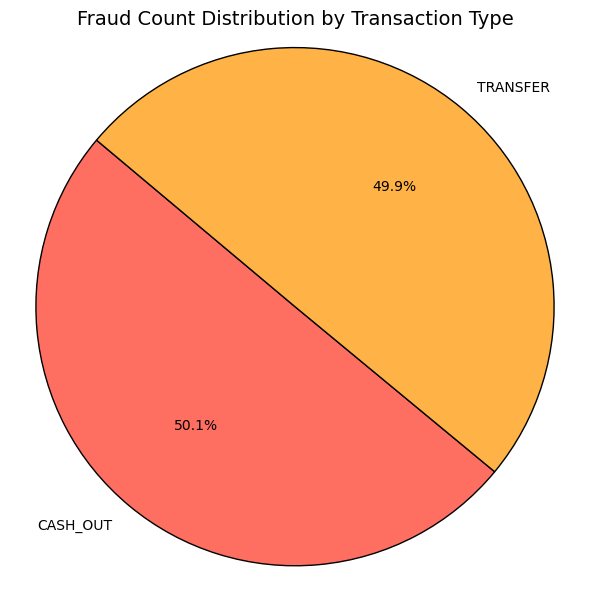

In [14]:
fraud_counts = df[df['is_fraud'] == 1]['transac_type'].value_counts()
colors = ['#FF6F61', '#FFB347', '#FFD700', '#8ECFC9', '#6495ED', '#DDA0DD'][:len(fraud_counts)]

plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Fraud Count Distribution by Transaction Type', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

From observation of transaction type, we find that all fraudulent transactions in this dataset all fall in either CASH_OUT or TRANSFER type. This indicates that these types of transactions are more susceptible to fraud.

## Amount

In [15]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [16]:
#statistics on normal transactions
pd.DataFrame.describe(df[df["is_fraud"] == 0].amount)

count    6,354,407.00
mean       178,197.04
std        596,236.98
min              0.01
25%         13,368.40
50%         74,684.72
75%        208,364.76
max     92,445,516.64
Name: amount, dtype: float64

In [17]:
#statistics on fraudulent transactions
pd.DataFrame.describe(df[df["is_fraud"] == 1].amount)

count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: amount, dtype: float64

By comparing the two statistics, we can see that fraudulent transactions involve higher amount of money. Other notable statistics are:
- high standard deviation
- minimum amount of 0.00
Which might suggests anomalous transaction amounts and/or pattern.

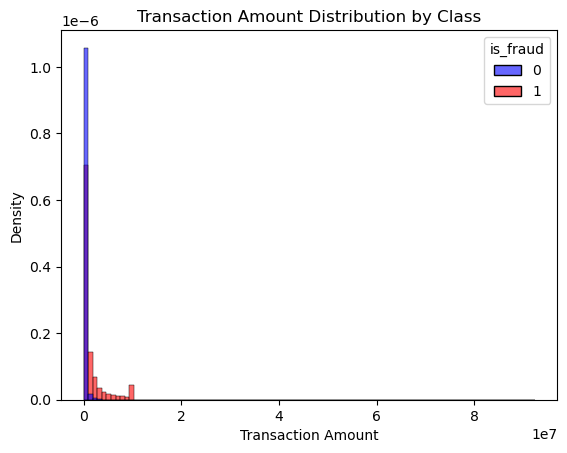

In [18]:
sns.histplot(df, x="amount", hue="is_fraud", bins=100, stat="density", common_norm=False,
             palette={0: "blue", 1: "red"}, alpha=0.6)
plt.xlabel("Transaction Amount")
plt.title("Transaction Amount Distribution by Class")
plt.show()

In [19]:
df[df['amount'] == 0]

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
2736447,212,CASH_OUT,0.00,acc1367255,0.00,0.00,acc1528621,0.00,0.00,1,0
3247298,250,CASH_OUT,0.00,acc7722951,0.00,0.00,acc2508358,0.00,0.00,1,0
3760289,279,CASH_OUT,0.00,acc8728419,0.00,0.00,acc6693751,"538,547.63","538,547.63",1,0
5563714,387,CASH_OUT,0.00,acc1395145,0.00,0.00,acc2877303,"7,970,766.57","7,970,766.57",1,0
5996408,425,CASH_OUT,0.00,acc910700,0.00,0.00,acc7166019,"76,759.90","76,759.90",1,0
5996410,425,CASH_OUT,0.00,acc5893126,0.00,0.00,acc8475247,"2,921,531.34","2,921,531.34",1,0
6168500,554,CASH_OUT,0.00,acc4444793,0.00,0.00,acc2138541,"230,289.66","230,289.66",1,0
6205440,586,CASH_OUT,0.00,acc4558495,0.00,0.00,acc3365751,"1,328,472.86","1,328,472.86",1,0
6266414,617,CASH_OUT,0.00,acc3325066,0.00,0.00,acc670187,0.00,0.00,1,0
6281483,646,CASH_OUT,0.00,acc5214484,0.00,0.00,acc2326618,0.00,0.00,1,0


Note that transaction amount is skewed and all transaction amount = 0 is fraudulent.

## Time Index

Explore any time-based pattern of fraudulent transactions.

Text(0.5, 1.0, 'Fraud Frequency Over Time')

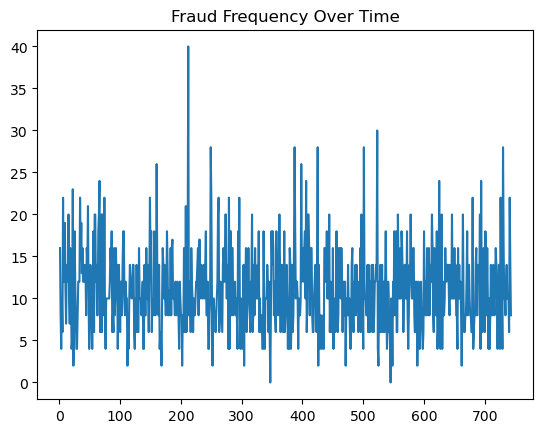

In [20]:
fraud_over_time = df.groupby('time_ind')['is_fraud'].sum()
plt.plot(fraud_over_time)
plt.title("Fraud Frequency Over Time")

Text(0.5, 1.0, 'Genuine Frequency Over Time')

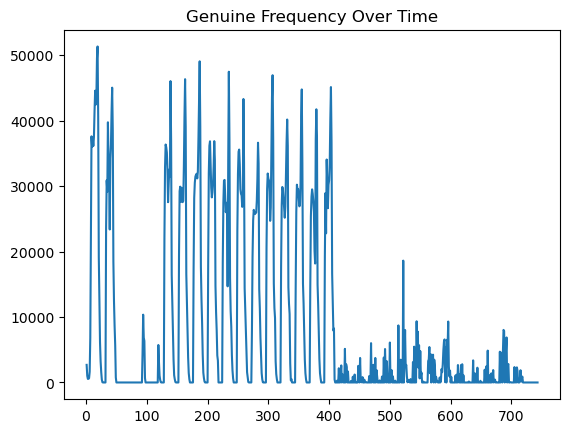

In [21]:
non_fraud_over_time = df.groupby('time_ind')['is_fraud'].count() - df.groupby('time_ind')['is_fraud'].sum()
plt.plot(non_fraud_over_time)
plt.title("Genuine Frequency Over Time")

Resulting graph shows that fraudulent transactions are equally likely to occur during all time steps while there are spikes and inconsistencies in genuine transactions.

In [22]:
df['hour_of_day'] = df['time_ind']%24

Text(0.5, 1.0, 'Fraud Frequency During Hour of Day')

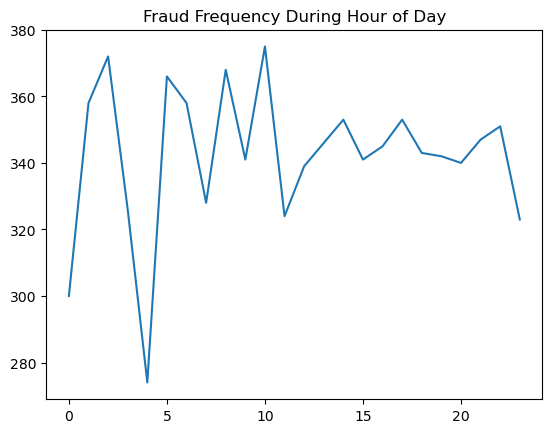

In [23]:
fraud_hr = df.groupby('hour_of_day')['is_fraud'].sum()
plt.plot(fraud_hr)
plt.title("Fraud Frequency During Hour of Day")

Text(0.5, 1.0, 'Genuine Frequency During Hour of Day')

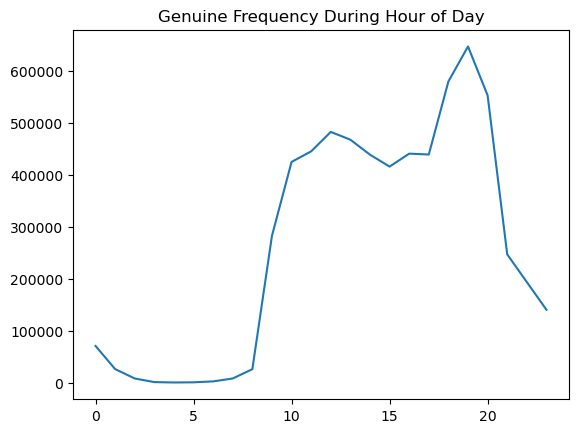

In [24]:
gen_hr = df.groupby('hour_of_day')['is_fraud'].count() -df.groupby('hour_of_day')['is_fraud'].sum()
plt.plot(gen_hr)
plt.title("Genuine Frequency During Hour of Day")

Observing the hour of day the fraudulent and genuine transactions occur, we can observe that fraudulent transactions can occur throughout 24 hours but genuine transactions are more likely to occur during 8-24hrs.

## Balances

### Src Balance

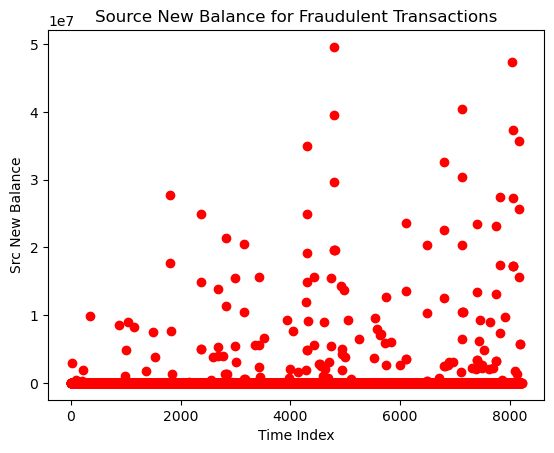

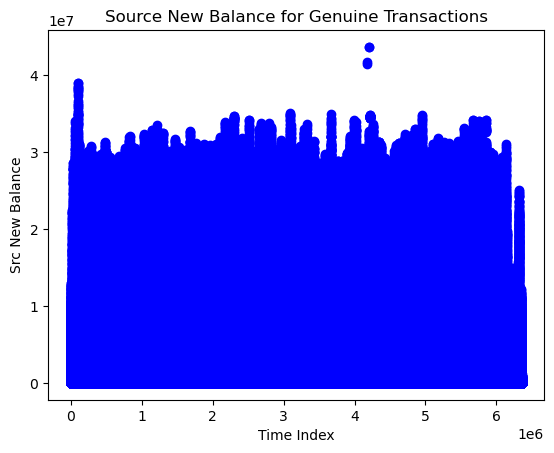

In [25]:
#src_new_bal
plt.scatter(range(len(df[df["is_fraud"] == 1])), df[df["is_fraud"] == 1]['src_new_bal'], color='red')
plt.title('Source New Balance for Fraudulent Transactions')
plt.xlabel('Time Index')
plt.ylabel('Src New Balance')

plt.show()

plt.scatter(range(len(df[df["is_fraud"] == 0])), df[df["is_fraud"] == 0]['src_new_bal'], color='blue')
plt.title('Source New Balance for Genuine Transactions')
plt.xlabel('Time Index')
plt.ylabel('Src New Balance')

plt.show()

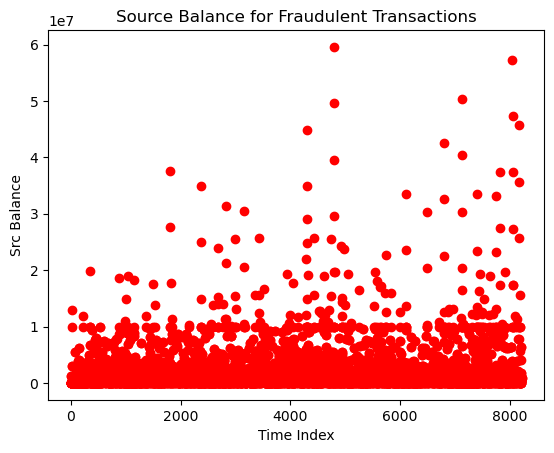

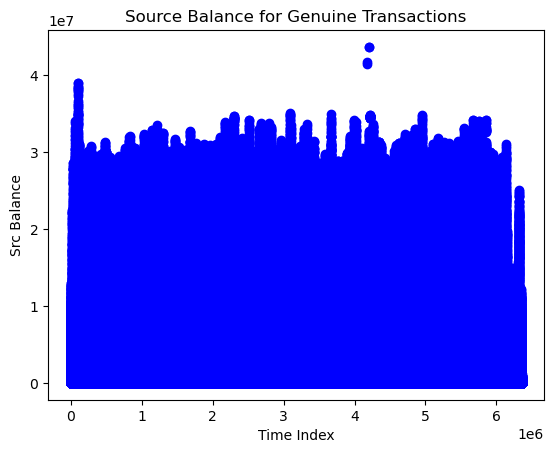

In [26]:
#src_bal
plt.scatter(range(len(df[df["is_fraud"] == 1])), df[df["is_fraud"] == 1]['src_bal'], color='red')
plt.title('Source Balance for Fraudulent Transactions')
plt.xlabel('Time Index')
plt.ylabel('Src Balance')

plt.show()

plt.scatter(range(len(df[df["is_fraud"] == 0])), df[df["is_fraud"] == 0]['src_new_bal'], color='blue')
plt.title('Source Balance for Genuine Transactions')
plt.xlabel('Time Index')
plt.ylabel('Src Balance')

plt.show()

### Dst Balance

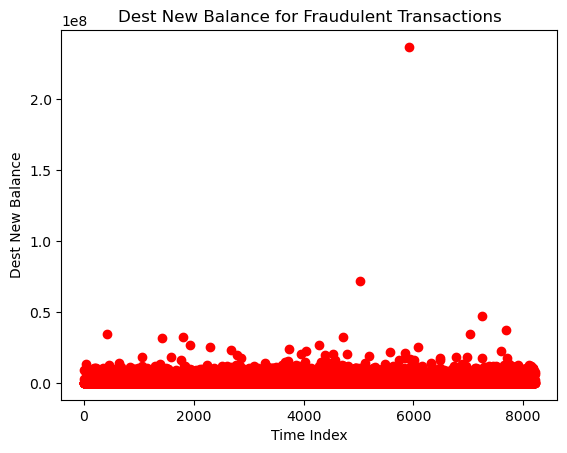

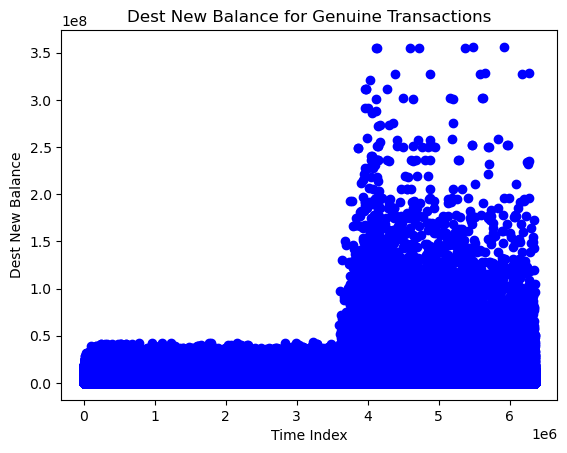

In [27]:
plt.scatter(range(len(df[df["is_fraud"] == 1])), df[df["is_fraud"] == 1]['dst_new_bal'], color='red')
plt.title('Dest New Balance for Fraudulent Transactions')
plt.xlabel('Time Index')
plt.ylabel('Dest New Balance')

plt.show()

plt.scatter(range(len(df[df["is_fraud"] == 0])), df[df["is_fraud"] == 0]['dst_new_bal'], color='blue')
plt.title('Dest New Balance for Genuine Transactions')
plt.xlabel('Time Index')
plt.ylabel('Dest New Balance')

plt.show()

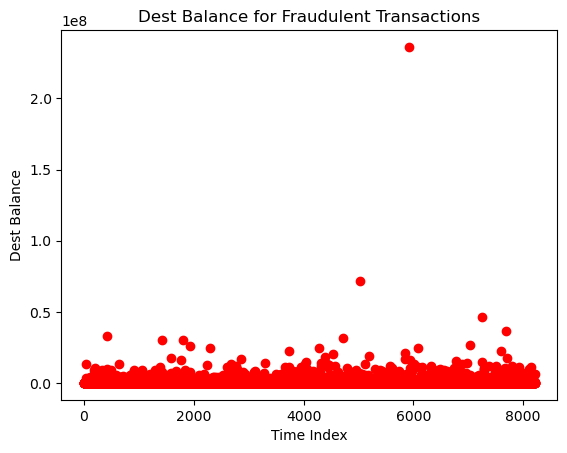

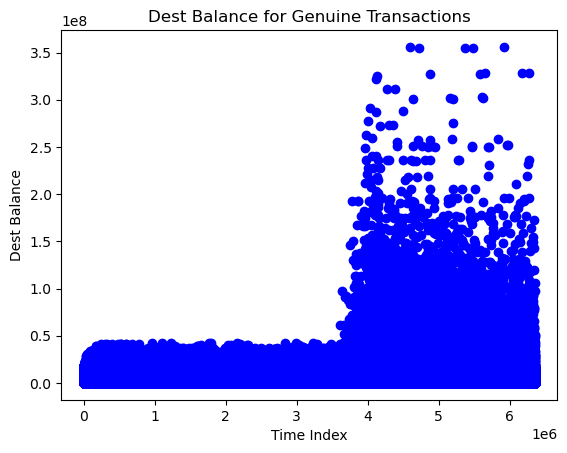

In [28]:
plt.scatter(range(len(df[df["is_fraud"] == 1])), df[df["is_fraud"] == 1]['dst_bal'], color='red')
plt.title('Dest Balance for Fraudulent Transactions')
plt.xlabel('Time Index')
plt.ylabel('Dest Balance')

plt.show()

plt.scatter(range(len(df[df["is_fraud"] == 0])), df[df["is_fraud"] == 0]['dst_bal'], color='blue')
plt.title('Dest Balance for Genuine Transactions')
plt.xlabel('Time Index')
plt.ylabel('Dest Balance')

plt.show()

### Mismatch


In [29]:
# Basic sanity check: src_new_bal = src_bal - amount?
(df['src_new_bal'] != df['src_bal'] - df['amount']).mean()

np.float64(0.8509068591240715)

In [30]:
# Same for recipient
has_dst = df['dst_bal'].notna()
(df.loc[has_dst, 'dst_new_bal'] != df.loc[has_dst, 'dst_bal'] + df.loc[has_dst, 'amount']).mean()

np.float64(0.7444533855550072)

The original balance and new balance for both the source and destination are not consistent.

### Summary

A noteworthy observation is that most fraudulent transactions deplete the source account new balance to zero. This suggests fraudulent operations to drain a source account and is useful for detecting fraudulent transactions. Furthermore, we can also observe that fraudulent transactions has dst_bal and dst_new_bal closer to 0 on average compared to genuine transactions.

## Is flagged fraud?

Explore if fraudulent transactions are flagged as an illegal attempt.

In [31]:
pd.crosstab(df['is_fraud'], df['is_flagged_fraud'], margins=True)

is_flagged_fraud,0,1,All
is_fraud,,,
0,6354407,0,6354407
1,8197,16,8213
All,6362604,16,6362620


Investigation of the is_flagged_fraud feature shows that the column has minimal relation to our target and only caught 16 truly fradulent transactions.

## Bivariate Analysis

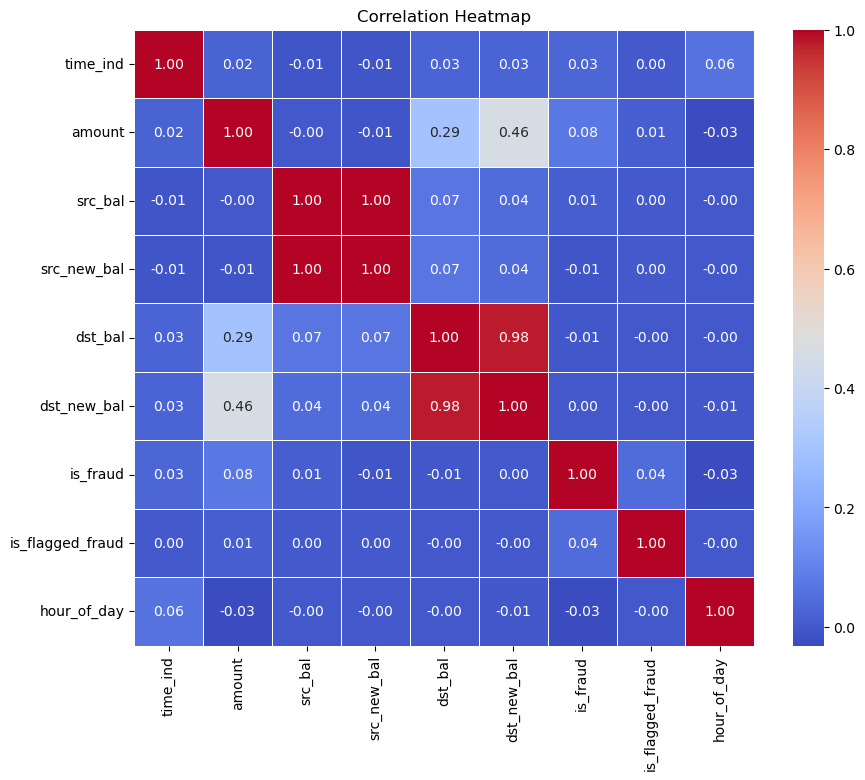

In [32]:
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The correlation matrix does not display any significant relationship between our target class, is_fraud, and other features. However, we can see close relationships between old and new balances.

# Reflections

The dataset is highly imbalanced, with the majority being genuine transactions, which must be accounted for during model training. Furthermore, by nature of the fraud detection problem we value true positives, therefore our emphasis would be on the recall score.

Notable columns that is relevant to the prediction is as follows:
- transac_type
- amount
- src_bal
- src_new_bal
- dst_bal
- dst_new_bal
- hour_of_day (from time_ind)